In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_gaussians(t,T):
    y1 = np.exp(-(t-T*0.15)**2/(2*15**2))
    y2 = np.exp(-(t-T*0.40)**2/(2*25**2))/3
    y3 = np.exp(-(t-T*0.80)**2/(2*15**2))/2
    return y1+y2+y3

class Neuron():
    def __init__(self, V0=-60, Ie=4, P_s0=0, num_synapses=4, neur_type=0):
        # neuron's electric constants:
        self.neur_type = neur_type
        self.Ie = Ie   # external current, nA
        self.tau = 10 if neur_type==0 else 20 # ms
        self.Vth = -55 # threshold after which an AP is fired,   mV
        self.Vr = -70    # reset voltage (after an AP is fired), mV
        self.EL = -65    # mV
        self.Rm = 10     # MOhm
        self.Es = 100   # equilibrium potential for the synapse
        self.P_s = 0   # probability of channel conductance opening (set to 1 after an upstream neuron spikes)
        self.rm = 0.142857

        self.Vspike = 0
        self.AP = 0
        self.incoming_transmitter = 0
        self.I_tot = 0
        
        self.refractory_period = 1 # ms
        self.time_since_last_spike = 1
        

        """ currents carried across the membrane by ion pumps that maintain the 
        concentration gradients.By convention, the membrane current is defined 
        as positive when positive ions leave the neuron and negative when positive 
        ions enter the neuron."""

        
        # maximum conductance ofchannels of k-th type (depends on a conductance of one 
        # opened channel and on a number of channels in the membrane)
        self.gNabar = 1.2
        self.gKbar = 0.36
        self.glbar = 0.003
        self.gSbar = 0.35 #0.05*0.003

        # Intial conditions
        self.V = V0 # intial membrane voltage
        
        # initialize the axon's signalaling (what neurotransmitter this neuron can release):
        self.num_synapses = num_synapses
        self.synapses = []
        for i in range(self.num_synapses):
            self.synapses.append(self.Synapse())


    def step(self, dt):
        """
        MAKE ONE TIME STEP TO UPDATE THE NEURON'S PARAMETERS
        """
        for synapse in self.synapses:
            synapse.update(dt)
        self.P_s = sum([self.synapses[i].P_s for i in range(self.num_synapses)])
        
        # IAF model: dV/dt is membrane current.
#         dV = (self.EL-self.V+self.Rm*self.Ie)/self.tau*dt # self.Ie + self.Ii + Iin + Ifb + In
        
        dV = (-(self.V - self.EL)
              - self.rm * self.gSbar * self.P_s * (self.V-self.Es)
              + self.Rm*self.Ie)/self.tau*dt

        self.time_since_last_spike += dt
        
        if self.AP==1:
            self.AP = 0
            self.V = self.Vr

        # if the threshold voltage is reached, fire and action potential:
        if self.V > self.Vth and self.AP==0 and self.time_since_last_spike >= self.refractory_period:
            self.V = self.Vspike
            self.AP = 1
            self.time_since_last_spike = 0
        
        if self.AP==0:
            self.V = self.V + dV
        
        return self.V
    
    class Synapse:
        def __init__(self):
            self.alpha = 0.93 # 1/ms
            self.beta = 0.19  # 1/ms
            self.P_s = 0
            self.incoming_transmitter = 0
            
        def update(self, dt):
            if self.incoming_transmitter > 0:
                self.incoming_transmitter -= dt
                dP_s = (self.alpha*(1 - self.P_s) - self.beta*self.P_s)*dt
            else:
                dP_s = -self.beta*self.P_s*dt
            self.P_s += dP_s
            
            
def define_topology(NumOfNeurons, numOfSynapses, sparsity=0.5):
    # Define network topology:
    np.random.seed(10)
    route = np.random.choice([0,1], p=[sparsity, 1-sparsity], size=(NumOfNeurons,NumOfNeurons,numOfSynapses))
    for i in range(NumOfNeurons):
        route[i,i,:] = 0
    a = np.array(np.arange(NumOfNeurons))
    for i in range(numOfSynapses):
        b = np.delete(a,i)
        route[b,:,i] = 0
    return route

Text(0,0.5,'$I_{e}, nA$')

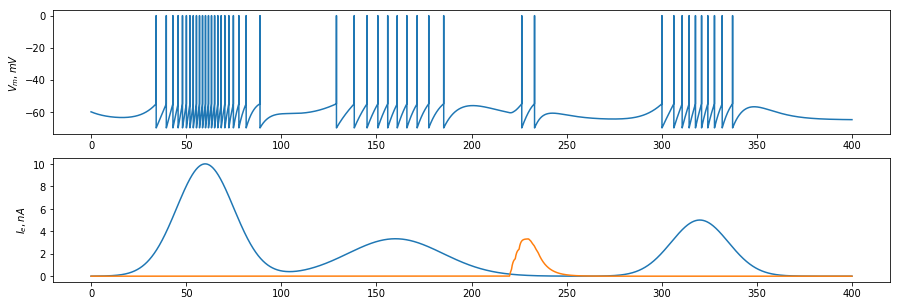

In [5]:
""" 
*******************  simulation 1 *******************
"""

I_peak = 10

neuron = Neuron(V0=-60, Ie=1.5, P_s0=0)
T = 400
dt = 0.01
V, Is = [], []
t = np.arange(0, T, step=dt)
c = 0
for i in t:
    neuron.Ie = I_peak*get_gaussians(i,T)
    if i in ([220,221,223,225]):
        neuron.synapses[c].incoming_transmitter = 10
        c += 1
    V.append(neuron.step(dt))
    Is.append(neuron.P_s)

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(t, V)
plt.ylabel('$V_{m}, mV$')

plt.subplot(2,1,2)
plt.plot(t, I_peak*get_gaussians(t,T))
plt.plot(t, Is)
plt.ylabel('$I_{e}, nA$')


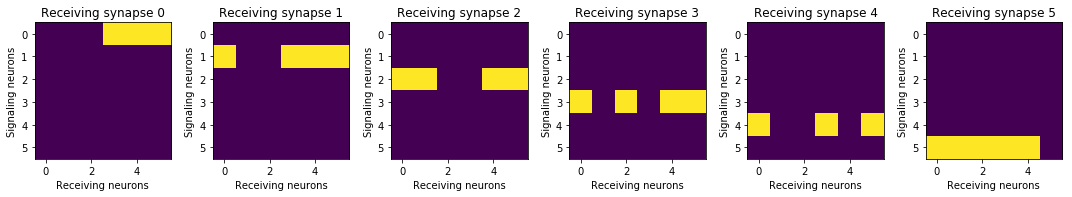

In [3]:
""" 
*******************  simulation 2 *******************
"""

# DEFINE SIMULATION PARAMETERS:
N = 6 # number neurons in the network
M = 6 # number of synapses a neuron has (not all of them have to receive connections from upstream neurons)
S = 0.3 # network's sparsity (how many synapses in the network receive no input from upstream neurons)
ts = 0.9 # time for which the neurotransmitter stays in the cleft until it is eliminated
T = 90 # length of simulation, ms
dt = 0.01 # time step in milliseconds

# create a list of neuron objects and populate it:
neurons = []
# Change some default initialization parameters:
for i in range(N):
    neurons.append(Neuron(Ie=3, num_synapses=M, neur_type=np.random.randint(2)))
for i in range(3,N):
    neurons[i].Ie = 0

# Define the network's topology:
route = define_topology(N, M, S)
# route = np.zeros_like(route)
# for i in range(N):
#     route[i,N-1,i] = 1
# route[-1,-1,-1] = 0

if N < 7:
    plt.figure(figsize=(15,5))
    for i in range(M):
        plt.subplot(1,M,i+1)
        plt.imshow(route[:,:,i])
        plt.ylabel('Signaling neurons')
        plt.xlabel('Receiving neurons')
        plt.title('Receiving synapse ' + str(i))
        plt.tight_layout()

t = np.arange(0, T, step=dt)
VV = np.zeros((N, len(t)))
Ps = np.zeros((N, len(t)))
APtimes = []
for tt in range(len(t)):
    
    if t[tt]>30 and t[tt]<40:
        neurons[0].Ie = 25
        neurons[1].Ie = 25
        neurons[2].Ie = 25
    else:
        neurons[0].Ie = 3
        neurons[1].Ie = 3
        neurons[2].Ie = 3
        
#     if t[tt]>80 and t[tt]<100:
#         neurons[3].Ie = 15
#         neurons[4].Ie = 15
#         neurons[5].Ie = 15
#     else:
#         neurons[3].Ie = 0
#         neurons[4].Ie = 0
#         neurons[5].Ie = 0

#     if t[tt]==20:
#         neurons[1].synapses[0].incoming_transmitter = 10
#         neurons[1].synapses[1].incoming_transmitter = 10
#         neurons[1].synapses[2].incoming_transmitter = 10
#         neurons[1].synapses[3].incoming_transmitter = 10
        
    for n in range(N):
        CN = neurons[n]
        VV[n,tt] = CN.step(dt)
        Ps[n,tt] = CN.P_s
    # tell relevant synapses in relevant downstream neurons which upstream neurons have fired:
    for source in range(N):
        for target in range(N):
#             target_synapses = route[source, target,:].astype('int').tolist()
            target_synapses = np.nonzero(route[source, target,:])[0].tolist()
#             print('target synapses:', target_synapses)
            for target_synapse in target_synapses:
                if neurons[source].AP==1:
                    APtimes.append(t[tt])
                    neurons[target].synapses[target_synapse].incoming_transmitter = ts
#                     print('s_neu:', source,'t_neu:', target, 't_syn:', target_synapse,
#                           'AP flags set in neurons:',[neurons[i].AP for i in range(N)])


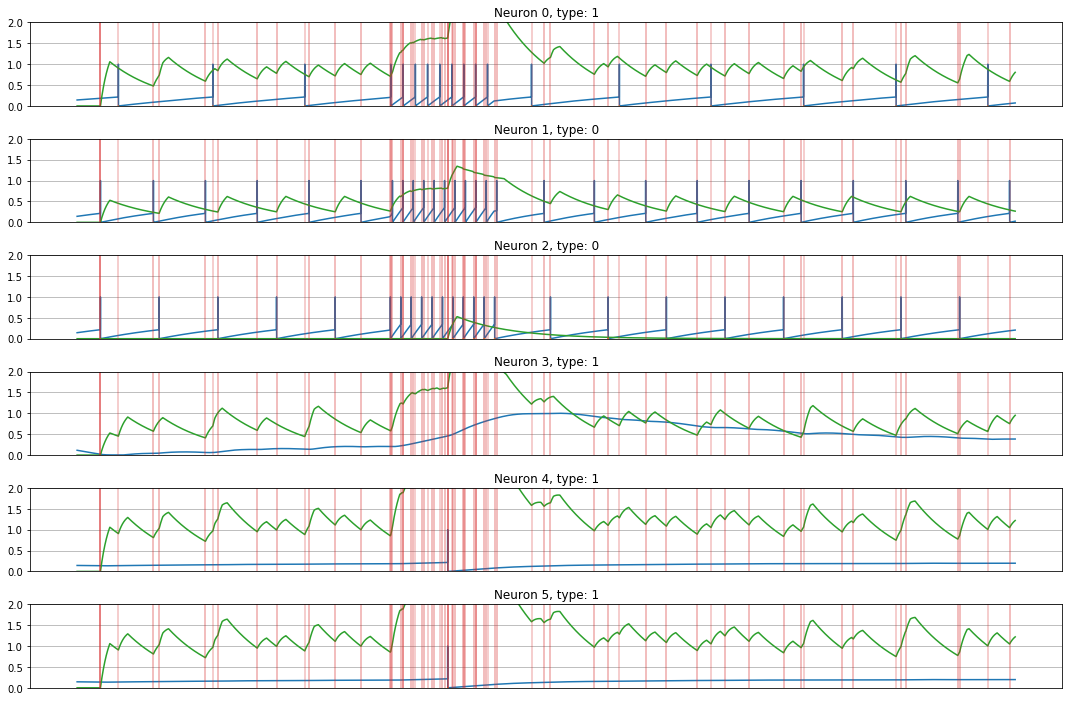

In [4]:
def axvlines(xs, ax=None, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = ax.get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot

def axhlines(ys, ax=None, **plot_kwargs):
    """
    Draw horizontal lines across plot
    :param ys: A scalar, list, or 1D array of vertical offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    ys = np.array((ys, ) if np.isscalar(ys) else ys, copy=False)
    lims = ax.get_xlim()
    y_points = np.repeat(ys[:, None], repeats=3, axis=1).flatten()
    x_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(ys), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scalex = False, **plot_kwargs)
    return plot

from sklearn import preprocessing
plt.figure(figsize=(15,10))
for i in range(N):
    plt.subplot(N,1,i+1)
    plt.plot(t, preprocessing.minmax_scale(VV[i,:]))
    plt.ylim(0,2)
    plt.plot(t, VV[i,:])
    plt.plot(t, Ps[i,:])
    plt.grid()
    plt.tight_layout()
    plt.gca().get_xaxis().set_ticks([])
    axvlines(APtimes, linewidth=0.15)
    plt.title('Neuron '+ str(i) +', type: ' + str(neurons[i].neur_type))
#     plt.gca().get_xaxis().set_ticks([])
